In [1]:
import subprocess
import os
import shutil
import warnings

warnings.filterwarnings("ignore")
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import toolsets.spectra_operations as so
import seaborn as sns
from tqdm import tqdm
from operator import itemgetter
import time
import numpy as np
import sys
sys.path.append('yuanyue_code')

import re
import pandas as pd

# import spectral_entropy as se

import toolsets.denoising_related_functions as de
import pandas as pd
import toolsets.ms2_spectra_plotter as ms2plotter
%load_ext autoreload
%autoreload 2
import toolsets.mass_to_formula as mtf
import toolsets.precursor_matching as pm
import toolsets.mass_recalibration as mr
# import requests
# import numpy as np

Compile the cython code is highly recommended!
i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot
I am precursor matching!
I am mass recalibration, usage: mass_recalibrate(data)
the data column must have columns of mix_label, Average_mz, PRECURSORMZ, msms
the msms should in a string format, e.g. mass1	intensity1
mass2	intensity2
....
the recalibrated column would be msms_recalibrated


In [161]:
data_height = pm.readin_MSDIAL("~/Documents/GitHub/Libgen_data/EAD/EAD_PFP/Height_0_20216191344.txt")
sample_list_cor = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD/EAD_PFP/standard_list.csv")
mass_error = 0.01
data_pfp = pm.precursor_matching(data_height, sample_list_cor, mass_error, ['[M+H]+', '[M+NH4]+','[M+Na]+'], "EAD_PFP", ifppm= False)
data_height = pm.readin_MSDIAL("~/Documents/GitHub/Libgen_data/EAD/EAD_HILIC/Height_2_2021619144.txt")
sample_list_cor = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD/EAD_HILIC/standard_list.csv")A

data_hilic = pm.precursor_matching(data_height, sample_list_cor, mass_error, ['[M+H]+', '[M+NH4]+','[M+Na]+'], "EAD_HILIC", ifppm = False)
data_ead = pd.concat([data_pfp, data_hilic], axis=0)

100%|██████████| 73/73 [00:05<00:00, 13.35it/s]


In [162]:
len(data_ead['InChIKey'].unique())

1900

In [163]:
# performing mass recalibration, if everything works out in previous step, this will work without issue
# the recalibrated msms is stored in new column, msms_recalibrated
data_ead_r = mr.data_recalibrate(data_ead, save_diff=True)

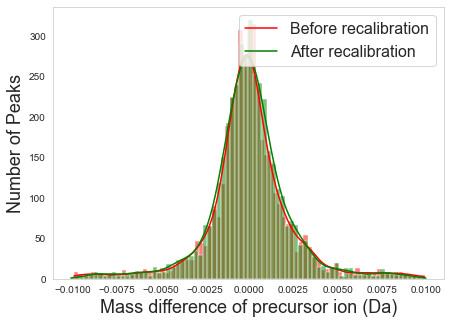

In [164]:
# this chunk of code is for seeing the difference of ms1 before and after the recalibration
# it is not necessary, if you want ot use it, the data_recalibrate must have the save_diff parameter set to be true

fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(data=data_ead_r, x="diff_raw", multiple="stack", kde = True, color = "red")
ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Mass difference of precursor ion (Da)", fontsize = 18)
ax.set_ylabel("Number of Peaks", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right',fontsize=16)
plt.show()
# plt.savefig('data_demo/recalibration.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [166]:
# this method creates consensus spectra
# default method is 'weighedaverage'
# another allowed method is 'consensus', which is the method described in 'Quality Control for Building Libraries from Electrospray Ionization Tandem Mass Spectra'
# the consensus spectra will be stored and replace the original 'msms' column
data_ead_r_u = so.duplicate_handling(data_ead_r, mass_error = 0.02, ifppm=False)
data_ead_r_u_d = so.denoising(data_ead_r_u,'msms', mass_error = 0.02, ifppm = False)

100%|██████████| 3272/3272 [3:03:50<00:00,  3.37s/it]    


In [167]:
data_ead_r_u_d_eva=so.denoising_evaluation(data_ead_r_u_d,msms1 = 'msms', msms2 = 'msms_r_u_d', min_explained_intensity = 70, allowed_max_unassigned_intensity = 30)

In [168]:
data_ead_r_u_d_eva.head()

,NAME,key,PRECURSORMZ,InChIKey,Formula,ExactMass,Adduct,Spectrum_type,RETENTIONTIME,Average_mz,...,mix_label,Ion_mode,msms_recalibrated,diff_raw,diff_recalibrated,parent_ion,msms_r_u_d,explained_intensity,max_unassigned_intensity,evaluations
0,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+H]+,141.054625,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+H]+,MS2,0.305,141.0544,...,PFPpos_P N 32_EAD,P,50.016142\t736.0\n51.025053\t1515.0\n52.030624...,-0.000225,-0.000206,141.054419,50.016142\t11.3879\n51.025053\t23.441126\n52.0...,0.971534,0.866471,good quality
1,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+H]+,156.10191,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+H]+,MS2,2.582,156.10075,...,PFPpos_P N 32_EAD,P,50.014812\t66.0\n51.023723\t134.0\n51.939574\t...,-0.001160,-0.001128,156.100781,50.014812\t5.602716\n51.023723\t11.375212\n52....,0.913001,17.147708,good quality
3,2-METHOXYRESORCINOL,QFYYAIBEHOEZKC-UHFFFAOYSA-N[M+Na]+,163.036565,QFYYAIBEHOEZKC-UHFFFAOYSA-N,C7H8O3,140.04734,[M+Na]+,MS2,2.276,163.0387,...,PFPpos_P N 32_EAD,P,105.037568\t22.0\n115.046157\t35.0\n115.053517...,0.002135,0.002172,163.038737,105.037568\t0.11217\n115.046157\t0.178453\n115...,0.843075,11.038597,good quality
4,Arecoline,HJJPJSXJAXAIPN-UHFFFAOYSA-N[M+NH4]+,173.12845,HJJPJSXJAXAIPN-UHFFFAOYSA-N,C8H13NO2,155.09463,[M+NH4]+,MS2,2.237,173.13094,...,PFPpos_P N 32_EAD,P,113.986286\t22.0\n115.054537\t858.0\n116.06021...,0.002490,0.002536,173.130986,113.038645\t1.551481\n115.054412\t39.862994\n1...,0.757277,100.000000,flagged: high unassigned intensity
6,4-nitroquinoline 1-oxide,YHQDZJICGQWFHK-UHFFFAOYSA-N[M+H]+,191.045123,YHQDZJICGQWFHK-UHFFFAOYSA-N,C9H6N2O3,190.03784,[M+H]+,MS2,0.943,191.0451,...,PFPpos_P N 32_EAD,P,50.014112\t679.0\n51.023013\t2218.0\n52.019374...,-0.000023,0.000038,191.045161,50.014112\t3.456174\n51.023013\t11.28983\n52.0...,0.978842,1.364145,good quality


In [169]:
good_quality = data_ead_r_u_d_eva.loc[data_ead_r_u_d_eva['explained_intensity']>=0.7]

In [173]:
len(data_ead_r_u_d_eva['InChIKey'].unique())

1900

In [172]:
len(good_quality['InChIKey'].unique())

1859

In [174]:
1900-1859

41

In [146]:
from sklearn.linear_model import LinearRegression

In [158]:
lm.predict(x)

array([104.10574809, 104.10650809, 112.03857039, 121.06772577,
       174.05444474, 215.13824024, 215.13967024, 219.11358141,
       237.12091204, 241.09420321])

In [ ]:
data_ead_r_u_d = so.denoising(data_ead_r_u,'msms', mass_error = 0.02, ifppm = False)

In [12]:
data_ead_r_u_d_eva=so.denoising_evaluation(data_ead_r_u_d,msms1 = 'msms', msms2 = 'msms_r_u_d', min_explained_intensity = 70, allowed_max_unassigned_intensity = 30)

In [34]:
good_quality = data_ead_r_u_d_eva.loc[data_ead_r_u_d_eva['explained_intensity']>=0.7]

In [167]:
# good_quality.to_csv("~/Documents/GitHub/Libgen_data/EAD/good_quality.csv", index = False)

In [4]:
good_quality = pd.read_csv("~/Documents/GitHub/Libgen_data/EAD/good_quality.csv")

In [33]:
bad_quality = data_ead_r_u_d_eva.loc[data_ead_r_u_d_eva['explained_intensity']<0.7]

In [7]:
peak_intensity_valid = []
peak_intensity_noise =[]
num_peaks = 0
# num_peaks
for index, row in good_quality.iterrows():
    num_peaks = num_peaks+so.num_peaks(row['msms'])
    mass_temp, intensity_temp = so.break_spectra(row['msms_r_u_d'])
    peak_intensity_valid.extend(intensity_temp)
    intensity_noise_temp = so.identify_unassigned_intensity(row['msms'], row['msms_r_u_d'])
    if intensity_noise_temp!=-1:
        peak_intensity_noise.extend(intensity_noise_temp)

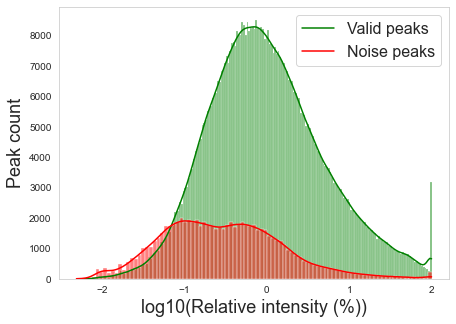

In [11]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(np.log10(peak_intensity_valid), multiple="stack", kde = True, color = 'green')
ax = sns.histplot(np.log10(peak_intensity_noise),  multiple="stack", kde = True,color = 'red')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("log10(Relative intensity (%))", fontsize = 18)
ax.set_ylabel("Peak count", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Valid peaks","Noise peaks"], loc = 'upper right',fontsize=16)
plt.savefig('data/denoising_good.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [165]:
from statsmodels.stats.weightstats import ztest as ztest


In [166]:
ztest(peak_intensity_valid, peak_intensity_noise, value=0)

(66.07243415595397, 0.0)

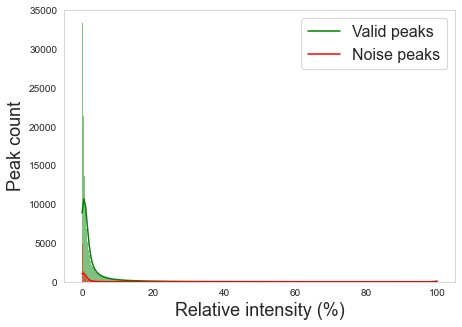

In [153]:
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
ax= sns.histplot(peak_intensity_valid, multiple="stack", kde = True, color = 'green')
ax = sns.histplot(peak_intensity_noise,  multiple="stack", kde = True,color = 'red')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Relative intensity (%)", fontsize = 18)
ax.set_ylabel("Peak count", fontsize = 18)
ax.grid(False)
plt.legend(labels=["Valid peaks","Noise peaks"], loc = 'upper right',fontsize=16)
plt.savefig('data/denoising.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

In [93]:
# calculating normalized entropy
normalized_entropy =[]
normalized_entroy_denoised = []
for index, row in data.iterrows():
    normalized_entropy.append(so.normalized_entropy(row['msms']))
    normalized_entroy_denoised.append(so.normalized_entropy(row['msms_denoised']))
data['normalized_entropy'] = normalized_entropy
data['normalized_entroy_denoised']=normalized_entroy_denoised

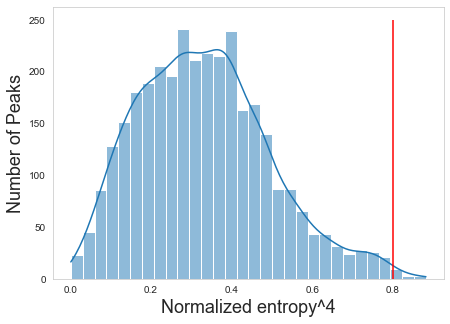

In [124]:
# plotting distribution of normalized entropy, not necessary
# fig, ax = plt.subplots(
#     figsize = (7, 5)
#                       )
# ax= sns.histplot(data=data, x="normalized_entroy_denoised", multiple="stack", kde = True,
#                  # hue="evaluations"
#                  )
# # ax.yaxis
# plt.vlines(x =0.8, ymin = 0, ymax=250,colors='red')
# # ax = sns.histplot(data=data_ead_r, x="diff_recalibrated", multiple="stack", kde = True,color = "green")
# # ax.set_title("Peak number difference after denoising", fontsize = 16)
# ax.set_xlabel("Normalized entropy^4", fontsize = 18)
# ax.set_ylabel("Number of Peaks", fontsize = 18)
# ax.grid(False)
# # plt.legend(labels=["Before recalibration","After recalibration"], loc = 'upper right')
# plt.savefig('data/normalized_entropy.tiff', dpi = 300,facecolor = 'white', edgecolor = 'white')

# final verdict:
# there are also other useful tools upon request: include but not limit to: entropy similarity calculation, fast search/open search against public libraries, etc
